# EDGS: Eliminating Densification for Gaussian Splatting
EDGS improves 3D Gaussian Splatting by removing the need for densification. It starts from a dense point cloud initialization based on 2D correspondences, leading to:
- ⚡ Faster convergence (only 25% of training time)
 - 🌀 Higher rendering quality
 - 💡 No need for progressive densification

## 1. Installation

In [ ]:
# Clone repo and initialize submodules
!git clone https://github.com/CompVis/EDGS.git --recursive
%cd EDGS

# Create and activate conda environment (if using a local runtime)
# For Colab, we use pip-based installs
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -e submodules/gaussian-splatting/submodules/diff-gaussian-rasterization
!pip install -e submodules/gaussian-splatting/submodules/simple-knn
!pip install wandb hydra-core tqdm torchmetrics lpips matplotlib rich plyfile
!pip install -e submodules/RoMa

!pip install pycolmap
!pip install wandb hydra-core tqdm torchmetrics lpips matplotlib rich plyfile imageio imageio-ffmpeg
# Stuff necessary for gradio and visualizations
!pip install gradio 
!pip install plotly scikit-learn moviepy==2.1.1 ffmpeg
!pip install opencv-python


In [ ]:
%cd notebooks

## 2. Import libraries

In [ ]:
import torch
import numpy as np
from matplotlib import pyplot as plt
# Enable interactive mode
# %matplotlib ipympl
%matplotlib inline

import sys
import os
sys.path.append("../")
sys.path.append("../submodules/gaussian-splatting")
from source.utils_aux import set_seed
import omegaconf
import wandb
import hydra
from hydra import initialize, compose
import random

from omegaconf import OmegaConf
from source.trainer import EDGSTrainer

In [ ]:
with initialize(config_path="../configs", version_base="1.1"):
    cfg = compose(config_name="train")
print(OmegaConf.to_yaml(cfg))

# 3. Init input parameters 

## 3.1 Optionally preprocess video

In [ ]:
PATH_TO_VIDEO = "../assets/examples/video_fruits.mp4"
num_ref_views = 16 # how many frames you want to extract from video and colmap
if False:
    # Full pipeline helpers
    from gradio_demo import preprocess_input
    from source.utils_preprocess import read_video_frames, preprocess_frames, select_optimal_frames, save_frames_to_scene_dir, run_colmap_on_scene
    from source.visualization import generate_circular_camera_path, save_numpy_frames_as_mp4, generate_fully_smooth_cameras_with_tsp, put_text_on_image
    # Change to your path
    images, scene_dir = preprocess_input(PATH_TO_VIDEO, num_ref_views, num_corrs)
    shutil.copytree(scene_dir, '../assets/video_colmaped',  dirs_exist_ok=True)
    


In [4]:
# Update the config with your settings
cfg.wandb.name="EDGS.demo.scene"
cfg.wandb.mode="disabled" # "online" 
cfg.gs.dataset.model_path="./scene_edgsed/"  # "change this to your path to the processed scene"
cfg.gs.dataset.source_path="../assets/scene_colmaped/" # "change this to your path"
# Optionally for video processed
# cfg.gs.dataset.source_path="../assets/video_colmaped/"
cfg.gs.dataset.images="images"
cfg.gs.opt.TEST_CAM_IDX_TO_LOG=12 
cfg.train.gs_epochs=30000
cfg.gs.opt.opacity_reset_interval=1_000_000
cfg.train.no_densify=True
cfg.init_wC.matches_per_ref=15_000
cfg.init_wC.nns_per_ref=3
cfg.init_wC.num_refs=180
cfg.init_wC.roma_model="outdoors" 

# 4. Initilize model and logger

In [ ]:
_ = wandb.init(entity=cfg.wandb.entity,
                   project=cfg.wandb.project,
                   config=omegaconf.OmegaConf.to_container(cfg, resolve=True, throw_on_missing=True),
                   name = cfg.wandb.name,
                   mode = cfg.wandb.mode)
omegaconf.OmegaConf.resolve(cfg)
set_seed(cfg.seed)
# Init output folder
print("Output folder: {}".format(cfg.gs.dataset.model_path))
os.makedirs(cfg.gs.dataset.model_path, exist_ok=True)
# Init gs model
gs = hydra.utils.instantiate(cfg.gs) 
trainer = EDGSTrainer(GS=gs,
                      training_config=cfg.gs.opt,
                      device=cfg.device)

# 5. Init with matchings

In [6]:
trainer.timer.start()
trainer.init_with_corr(cfg.init_wC)
trainer.timer.pause() 

N_splats_at_init: 209252


/export/scratch/ra23mar/miniconda3/envs/edgs/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/export/scratch/ra23mar/miniconda3/envs/edgs/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using coarse resolution (560, 560), and upsample res (864, 864)
Once run full roma_model.match warp.shape: torch.Size([560, 560, 4])
Once run full roma_model.match certainty_warp.shape: torch.Size([560, 560])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [07:59<00:00,  2.66s/it]


N_splats_after_init: 2909252


### Visualize a few initial viewpoints

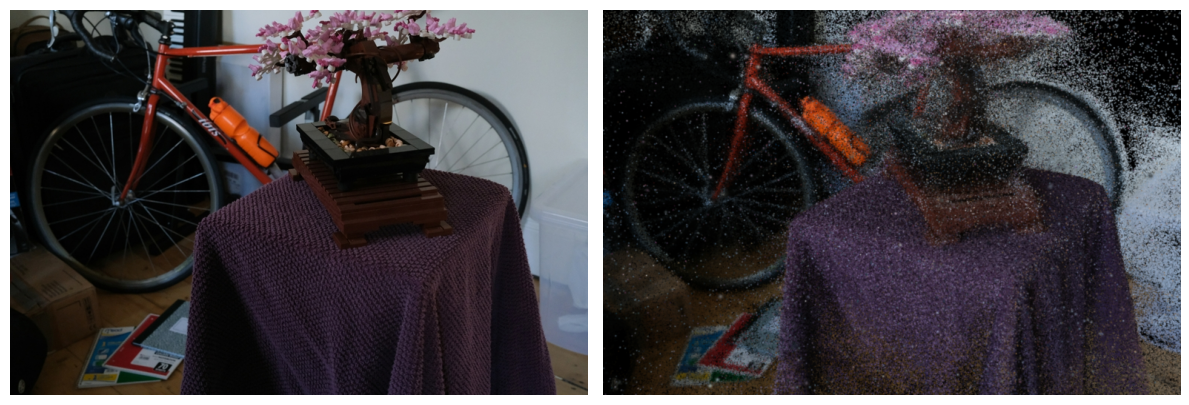

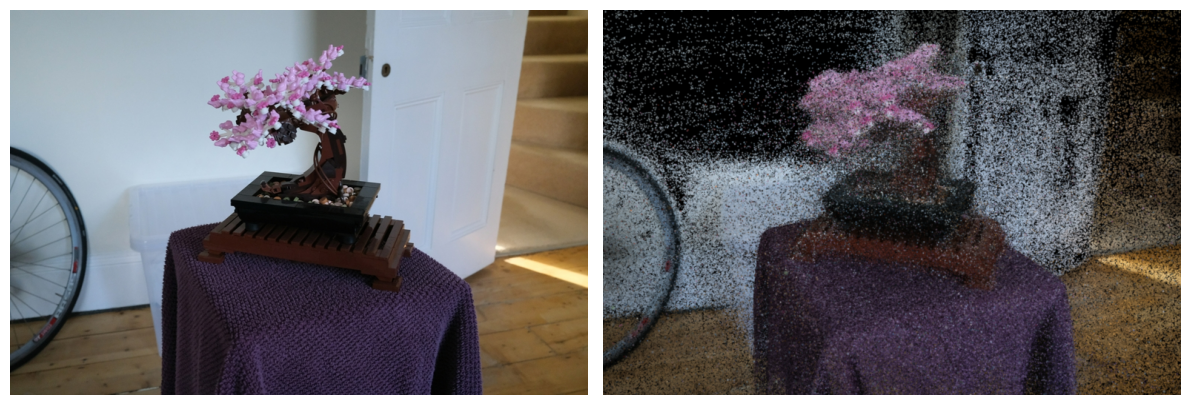

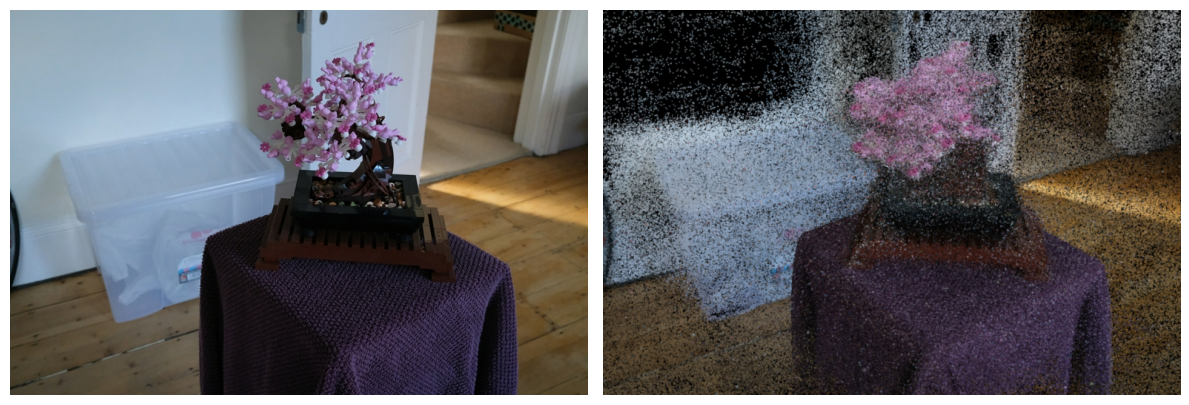

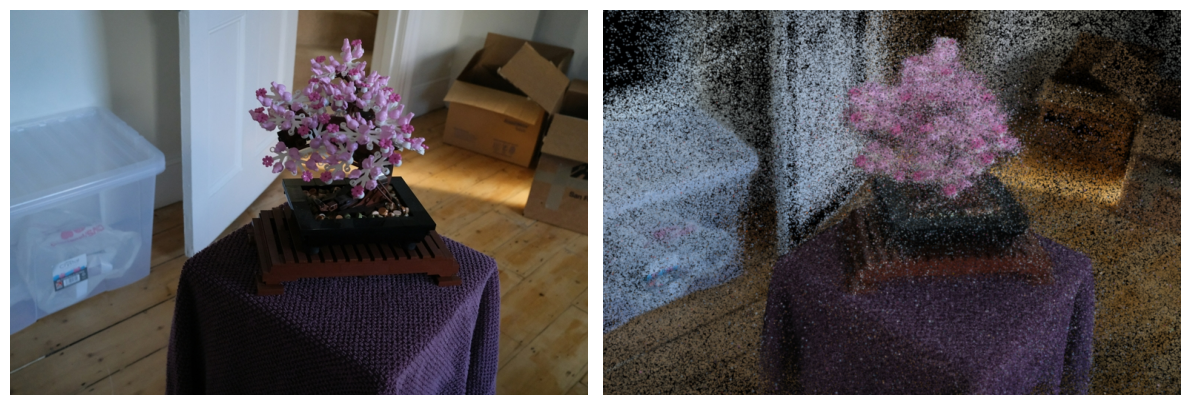

In [7]:
with torch.no_grad():
    viewpoint_stack = trainer.GS.scene.getTrainCameras()
    viewpoint_cams_to_viz = random.sample(trainer.GS.scene.getTrainCameras(), 4)
    for viewpoint_cam in viewpoint_cams_to_viz:
        render_pkg = trainer.GS(viewpoint_cam)
        image = render_pkg["render"]
        
        image_np = image.clone().detach().cpu().numpy().transpose(1, 2, 0)
        image_gt_np = viewpoint_cam.original_image.clone().detach().cpu().numpy().transpose(1, 2, 0)
    
        # Clip values to be in the range [0, 1]
        image_np = np.clip(image_np*255, 0, 255).astype(np.uint8) 
        image_gt_np = np.clip(image_gt_np*255, 0, 255).astype(np.uint8)  
    
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        ax[0].imshow(image_gt_np)
        ax[0].axis("off")
        ax[1].imshow(image_np)
        ax[1].axis("off")
        plt.tight_layout()
        plt.show()       

# 6.Optimize scene
Optimize first briefly for 5k steps and visualize results. We also disable saving of pretrained models. Train function can be changed for any other method

In [8]:
trainer.saving_iterations = []
cfg.train.gs_epochs=5_000
trainer.train(cfg.train)

Train 3DGS for 5000 iterations

Output()

/export/scratch/ra23mar/miniconda3/envs/edgs/lib/python3.9/site-packages/tqdm/rich.py:146: TqdmExperimentalWarning: rich is experimental/alpha
  return tqdm_rich(range(*args), **kwargs)


[ITER 500], #2696862 gaussians, Evaluating test: L1=0.040279,  PSNR=23.558345, SSIM=0.847978, LPIPS_splat=0.179998 

[ITER 500], #2696862 gaussians, Evaluating train: L1=0.033608,  PSNR=24.346497, SSIM=0.868645, LPIPS_splat=0.158322 

[ITER 1000], #2695113 gaussians, Evaluating test: L1=0.030621,  PSNR=26.061029, SSIM=0.900970, LPIPS_splat=0.127051 

[ITER 1000], #2695113 gaussians, Evaluating train: L1=0.026259,  PSNR=26.404464, SSIM=0.912740, LPIPS_splat=0.107189 

### Visualize same viewpoints

In [ ]:
with torch.no_grad():
    for viewpoint_cam in viewpoint_cams_to_viz:
        render_pkg = trainer.GS(viewpoint_cam)
        image = render_pkg["render"]
    
        image_np = image.clone().detach().cpu().numpy().transpose(1, 2, 0)
        image_gt_np = viewpoint_cam.original_image.clone().detach().cpu().numpy().transpose(1, 2, 0)
    
        # Clip values to be in the range [0, 1]
        image_np = np.clip(image_np*255, 0, 255).astype(np.uint8) 
        image_gt_np = np.clip(image_gt_np*255, 0, 255).astype(np.uint8)  
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        ax[0].imshow(image_gt_np)
        ax[0].axis("off")
        ax[1].imshow(image_np)
        ax[1].axis("off")
        plt.tight_layout()
        plt.show()

: 

### Save model

In [31]:
with torch.no_grad():
    trainer.save_model()


[ITER 5000] Saving Gaussians

[ITER 5000] Saving Checkpoint


# 7. Continue training until we reach total 30K training steps

In [33]:
cfg.train.gs_epochs=25_000
trainer.train(cfg.train)

Pretrain generator for 25000 iterations

Output()

[ITER 5228], #2267329 gaussians, Evaluating test: L1=0.017066,  PSNR=30.922582, SSIM=0.950781, LPIPS_splat=0.086333 

[ITER 5228], #2267329 gaussians, Evaluating train: L1=0.015319,  PSNR=31.172445, SSIM=0.957044, LPIPS_splat=0.068386 

[ITER 6228], #2117238 gaussians, Evaluating test: L1=0.016843,  PSNR=31.033513, SSIM=0.951287, LPIPS_splat=0.086227 

[ITER 6228], #2117238 gaussians, Evaluating train: L1=0.015027,  PSNR=31.329012, SSIM=0.958158, LPIPS_splat=0.067925 

[ITER 7228], #1976679 gaussians, Evaluating test: L1=0.016711,  PSNR=31.159565, SSIM=0.951720, LPIPS_splat=0.085188 

[ITER 7228], #1976679 gaussians, Evaluating train: L1=0.015423,  PSNR=31.365193, SSIM=0.956831, LPIPS_splat=0.068448 

[ITER 8228], #1843429 gaussians, Evaluating test: L1=0.016445,  PSNR=31.307585, SSIM=0.952562, LPIPS_splat=0.084383 

[ITER 8228], #1843429 gaussians, Evaluating train: L1=0.015101,  PSNR=31.423756, SSIM=0.957662, LPIPS_splat=0.067310 

[ITER 9228], #1720675 gaussians, Evaluating test: L1=0.016384,  PSNR=31.417037, SSIM=0.953729, LPIPS_splat=0.083138 

[ITER 9228], #1720675 gaussians, Evaluating train: L1=0.014957,  PSNR=31.562152, SSIM=0.959356, LPIPS_splat=0.065955 

[ITER 10228], #1610332 gaussians, Evaluating test: L1=0.015764,  PSNR=31.677755, SSIM=0.955173, LPIPS_splat=0.082012 

[ITER 10228], #1610332 gaussians, Evaluating train: L1=0.014577,  PSNR=31.811658, SSIM=0.960740, LPIPS_splat=0.064846 

[ITER 11228], #1511546 gaussians, Evaluating test: L1=0.015719,  PSNR=31.795658, SSIM=0.956093, LPIPS_splat=0.081276 

[ITER 11228], #1511546 gaussians, Evaluating train: L1=0.013963,  PSNR=32.135784, SSIM=0.962594, LPIPS_splat=0.063614 

[ITER 12228], #1425953 gaussians, Evaluating test: L1=0.015361,  PSNR=31.927712, SSIM=0.956808, LPIPS_splat=0.080297 

[ITER 12228], #1425953 gaussians, Evaluating train: L1=0.013744,  PSNR=32.250034, SSIM=0.963169, LPIPS_splat=0.062829 

[ITER 13228], #1349593 gaussians, Evaluating test: L1=0.015863,  PSNR=31.772544, SSIM=0.956342, LPIPS_splat=0.080279 

[ITER 13228], #1349593 gaussians, Evaluating train: L1=0.014253,  PSNR=32.043848, SSIM=0.962351, LPIPS_splat=0.063355 

[ITER 14228], #1282870 gaussians, Evaluating test: L1=0.015310,  PSNR=31.975517, SSIM=0.957361, LPIPS_splat=0.079151 

[ITER 14228], #1282870 gaussians, Evaluating train: L1=0.013660,  PSNR=32.395768, SSIM=0.963936, LPIPS_splat=0.061606 

[ITER 15228], #1237146 gaussians, Evaluating test: L1=0.014965,  PSNR=32.116886, SSIM=0.958471, LPIPS_splat=0.077644 

[ITER 15228], #1237146 gaussians, Evaluating train: L1=0.013139,  PSNR=32.642951, SSIM=0.965179, LPIPS_splat=0.059966 

[ITER 16228], #1237146 gaussians, Evaluating test: L1=0.014657,  PSNR=32.307088, SSIM=0.958775, LPIPS_splat=0.075697 

[ITER 16228], #1237146 gaussians, Evaluating train: L1=0.012758,  PSNR=32.802129, SSIM=0.966094, LPIPS_splat=0.058046 

[ITER 17228], #1237146 gaussians, Evaluating test: L1=0.014602,  PSNR=32.381589, SSIM=0.959498, LPIPS_splat=0.074540 

[ITER 17228], #1237146 gaussians, Evaluating train: L1=0.012883,  PSNR=32.866730, SSIM=0.966901, LPIPS_splat=0.056678 

[ITER 18228], #1237146 gaussians, Evaluating test: L1=0.014390,  PSNR=32.471773, SSIM=0.960237, LPIPS_splat=0.073533 

[ITER 18228], #1237146 gaussians, Evaluating train: L1=0.012283,  PSNR=33.120562, SSIM=0.967959, LPIPS_splat=0.055822 

[ITER 19228], #1237146 gaussians, Evaluating test: L1=0.014152,  PSNR=32.548530, SSIM=0.960315, LPIPS_splat=0.073165 

[ITER 19228], #1237146 gaussians, Evaluating train: L1=0.012456,  PSNR=33.033906, SSIM=0.967393, LPIPS_splat=0.055727 

[ITER 20228], #1237146 gaussians, Evaluating test: L1=0.014342,  PSNR=32.572400, SSIM=0.960384, LPIPS_splat=0.073282 

[ITER 20228], #1237146 gaussians, Evaluating train: L1=0.011990,  PSNR=33.273158, SSIM=0.968966, LPIPS_splat=0.054562 

[ITER 21228], #1237146 gaussians, Evaluating test: L1=0.014232,  PSNR=32.570450, SSIM=0.960732, LPIPS_splat=0.072579 

[ITER 21228], #1237146 gaussians, Evaluating train: L1=0.012131,  PSNR=33.242010, SSIM=0.968378, LPIPS_splat=0.054855 

[ITER 22228], #1237146 gaussians, Evaluating test: L1=0.014015,  PSNR=32.750072, SSIM=0.961398, LPIPS_splat=0.072361 

[ITER 22228], #1237146 gaussians, Evaluating train: L1=0.012067,  PSNR=33.364676, SSIM=0.969080, LPIPS_splat=0.054352 

[ITER 23228], #1237146 gaussians, Evaluating test: L1=0.013777,  PSNR=32.842476, SSIM=0.961594, LPIPS_splat=0.071888 

[ITER 23228], #1237146 gaussians, Evaluating train: L1=0.012085,  PSNR=33.342374, SSIM=0.969017, LPIPS_splat=0.053745 

[ITER 24228], #1237146 gaussians, Evaluating test: L1=0.014068,  PSNR=32.738539, SSIM=0.961206, LPIPS_splat=0.071647 

[ITER 24228], #1237146 gaussians, Evaluating train: L1=0.011694,  PSNR=33.596766, SSIM=0.969894, LPIPS_splat=0.053325 

[ITER 25228], #1237146 gaussians, Evaluating test: L1=0.013738,  PSNR=32.873506, SSIM=0.961779, LPIPS_splat=0.071460 

[ITER 25228], #1237146 gaussians, Evaluating train: L1=0.011492,  PSNR=33.653810, SSIM=0.970518, LPIPS_splat=0.052751 

[ITER 26228], #1237146 gaussians, Evaluating test: L1=0.013563,  PSNR=32.905883, SSIM=0.961865, LPIPS_splat=0.070935 

[ITER 26228], #1237146 gaussians, Evaluating train: L1=0.011979,  PSNR=33.451771, SSIM=0.969166, LPIPS_splat=0.053224 

[ITER 27228], #1237146 gaussians, Evaluating test: L1=0.013582,  PSNR=32.997347, SSIM=0.962034, LPIPS_splat=0.070995 

[ITER 27228], #1237146 gaussians, Evaluating train: L1=0.011476,  PSNR=33.741877, SSIM=0.970336, LPIPS_splat=0.052365 

[ITER 28228], #1237146 gaussians, Evaluating test: L1=0.013849,  PSNR=32.830977, SSIM=0.961764, LPIPS_splat=0.071507 

[ITER 28228], #1237146 gaussians, Evaluating train: L1=0.011905,  PSNR=33.552510, SSIM=0.969095, LPIPS_splat=0.053532 

[ITER 29228], #1237146 gaussians, Evaluating test: L1=0.013514,  PSNR=32.989114, SSIM=0.962280, LPIPS_splat=0.070845 

[ITER 29228], #1237146 gaussians, Evaluating train: L1=0.011869,  PSNR=33.569258, SSIM=0.970055, LPIPS_splat=0.052502 

### Visualize same viewpoints

In [ ]:
with torch.no_grad():
    for viewpoint_cam in viewpoint_cams_to_viz:
        render_pkg = trainer.GS(viewpoint_cam)
        image = render_pkg["render"]
    
        image_np = image.clone().detach().cpu().numpy().transpose(1, 2, 0)
        image_gt_np = viewpoint_cam.original_image.clone().detach().cpu().numpy().transpose(1, 2, 0)
    
        # Clip values to be in the range [0, 1]
        image_np = np.clip(image_np*255, 0, 255).astype(np.uint8) 
        image_gt_np = np.clip(image_gt_np*255, 0, 255).astype(np.uint8)  
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        ax[0].imshow(image_gt_np)
        ax[0].axis("off")
        ax[1].imshow(image_np)
        ax[1].axis("off")
        plt.tight_layout()
        plt.show()

### Save model

In [34]:
with torch.no_grad():
    trainer.save_model()


[ITER 30000] Saving Gaussians

[ITER 30000] Saving Checkpoint
